In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import numpy as np
from cv import *

## Calibration and  distortion correction
Compute the camera calibration matrix and distortion coefficients given a set of chessboard images, and apply a distortion correction to raw images.

In [2]:
img = cv2.imread('test_images/straight_lines1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
objpoints, imgpoints = load_calibration_parameters(6, 9)
img_undistort = undistort(img, objpoints, imgpoints)

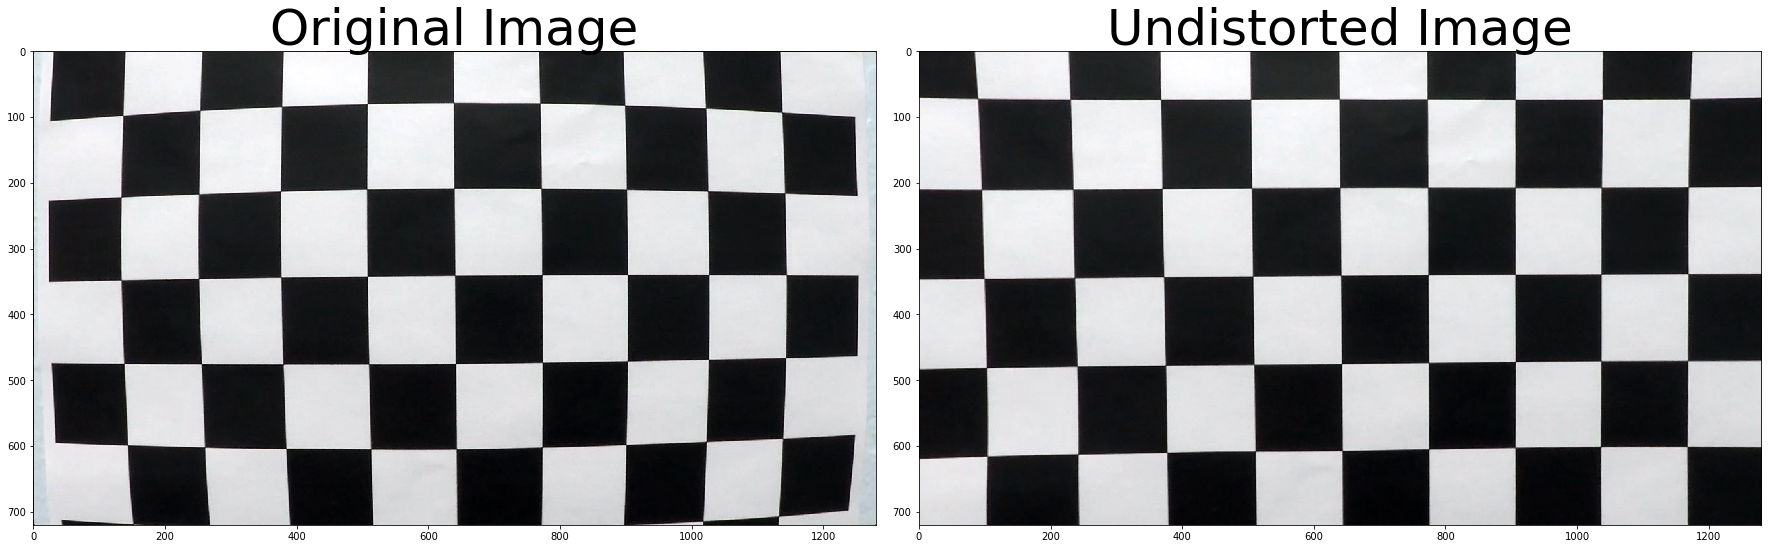

In [3]:
chessboard_distort = cv2.imread('camera_cal/calibration1.jpg')
chessboard_undistort = undistort(chessboard_distort, objpoints, imgpoints)
plot_comparison(
    chessboard_distort,
    chessboard_undistort,
    title1='Original Image',
    title2='Undistorted Image'
)

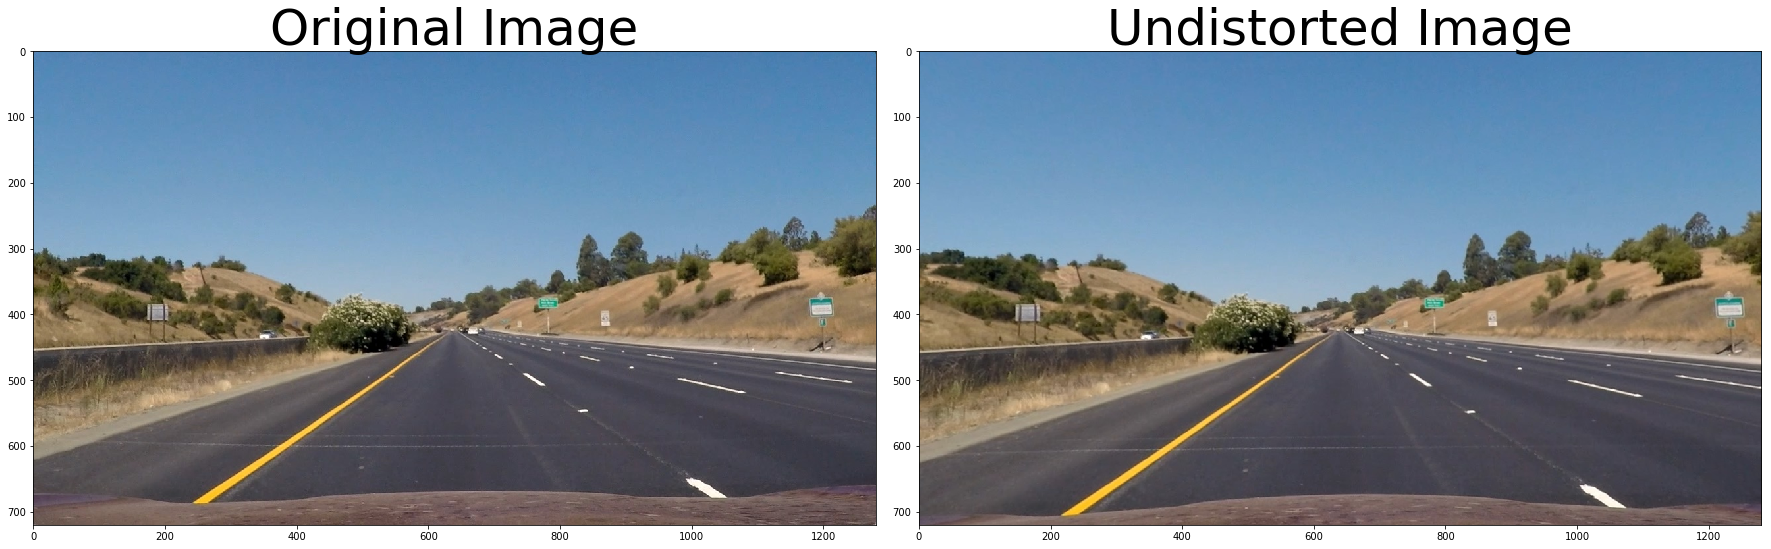

In [4]:
plot_comparison(
    img,
    img_undistort,
    title1='Original Image',
    title2='Undistorted Image'
)

## Exploring Colors and Gradients
Use color transforms, gradients, etc., to create a thresholded binary image.

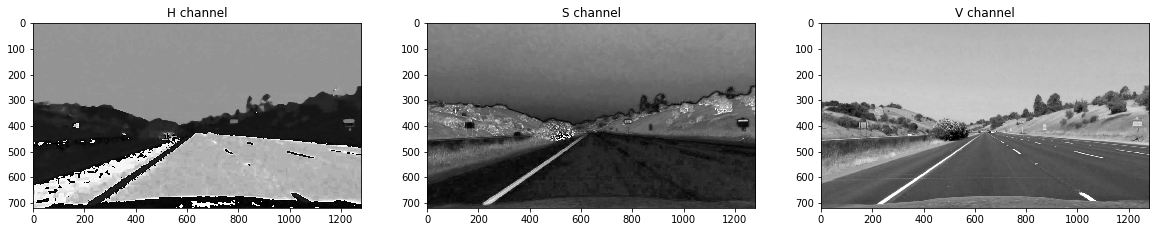

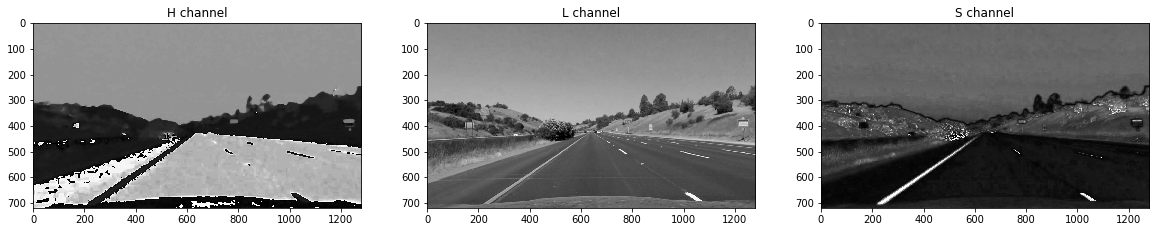

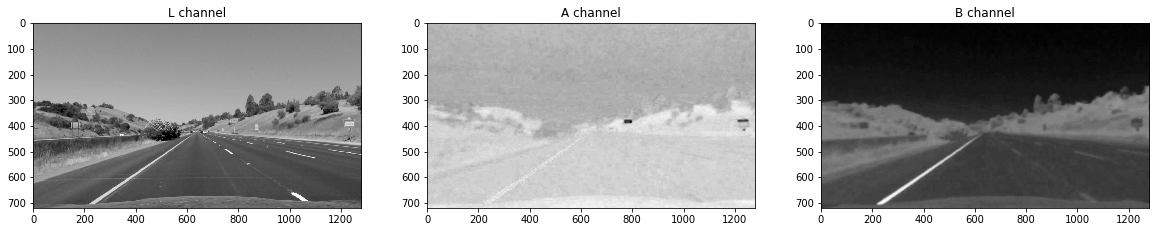

In [5]:
def plot_channels(img, channels='RGB'):
    # Isolate RGB channels
    c1 = img[:, :, 0]
    c2 = img[:, :, 1]
    c3 = img[:, :, 2]

    # Visualize the individual color channels
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
    ax1.set_title('%s channel' % channels[0])
    ax1.imshow(c1, cmap='gray')
    ax2.set_title('%s channel' % channels[1])
    ax2.imshow(c2, cmap='gray')
    ax3.set_title('%s channel' % channels[2])
    ax3.imshow(c3, cmap='gray')

plot_channels(img_undistort, channels='RGB')
plot_channels(cv2.cvtColor(img_undistort, cv2.COLOR_RGB2HSV), channels='HSV')
plot_channels(cv2.cvtColor(img_undistort, cv2.COLOR_RGB2HLS), channels='HLS')
plot_channels(cv2.cvtColor(img_undistort, cv2.COLOR_RGB2LAB), channels='LAB')
plot_channels(cv2.cvtColor(img_undistort, cv2.COLOR_RGB2LUV), channels='LUV')

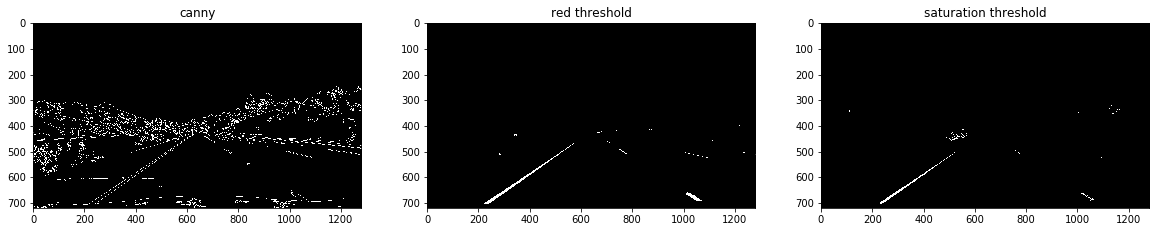

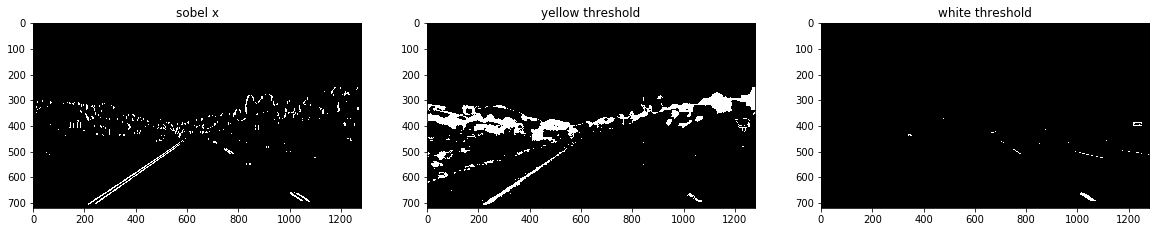

In [6]:
def white_threshold(img, thresh=(0, 255)):
    r = img[:, :, 0]
    g = img[:, :, 1]
    b = img[:, :, 2]
    binary_output = np.zeros_like(r)
    binary_output[(r >= thresh[0]) & (r <= thresh[1]) & 
                  (g >= thresh[0]) & (g <= thresh[1]) & 
                  (b >= thresh[0]) & (b <= thresh[1])] = 1
    return binary_output

def channel_threshold(img, channel=0, thresh=(0, 255)):
    c = img[:, :, channel]
    binary_output = np.zeros_like(c)
    binary_output[(c >= thresh[0]) & (c <= thresh[1])] = 1
    return binary_output

def combine_threshold(binary1, binary2):
    combined_binary = np.zeros_like(binary1)
    combined_binary[(binary1 == 1) | (binary2 == 1)] = 1
    return combined_binary

def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # take the gradient in x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)

    # calculate the magnitude
    mag_sobel = np.sqrt(sobelx ** 2)

    # scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255 * mag_sobel / np.max(mag_sobel))

    # create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    # inversed the mask, so can be combined with color threshold later on...
    binary_output = 1 - binary_output    
    return binary_output

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

# canny
test_img0 = canny(cv2.cvtColor(img_undistort, cv2.COLOR_RGB2GRAY), 0, 200)
# red threshold
test_img1 = channel_threshold(img_undistort, channel=0, thresh=(220, 255))
# saturation threshold
test_img2 = channel_threshold(cv2.cvtColor(img_undistort, cv2.COLOR_RGB2HLS), channel=2, thresh=(240, 255))
# sobel-x
test_img3 = mag_thresh(img_undistort, sobel_kernel=21, thresh=(0, 60))
# yellow threshold
test_img4 = channel_threshold(cv2.cvtColor(img_undistort, cv2.COLOR_RGB2HSV), channel=0, thresh=(20, 30))
# white threshold
test_img5 = white_threshold(img_undistort, thresh=(190, 255))

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.set_title('canny')
ax1.imshow(test_img0, cmap='gray')
ax2.set_title('red threshold')
ax2.imshow(test_img1, cmap='gray')
ax3.set_title('saturation threshold')
ax3.imshow(test_img2, cmap='gray')

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.set_title('sobel x')
ax1.imshow(test_img3, cmap='gray')              
ax2.set_title('yellow threshold')
ax2.imshow(test_img4, cmap='gray')              
ax3.set_title('white threshold')
ax3.imshow(test_img5, cmap='gray')                  

## Gradient and Threshold

In [7]:
img_binary = compose_threshold(img_undistort, verbose=1)

In [8]:
plot_comparison(
    img_undistort,
    img_binary,
    title1='Undistorted Image',
    title2='Binary Image',
    cmap2='gray'
)

## Region of Interest

src: [(570, 470), (720, 470), (1110, 720), (220, 720)]
dst: [(320, 0), (920, 0), (920, 720), (320, 720)]
region of interest: [[[ 510  470]
  [ 780  470]
  [1170  670]
  [ 160  670]]]


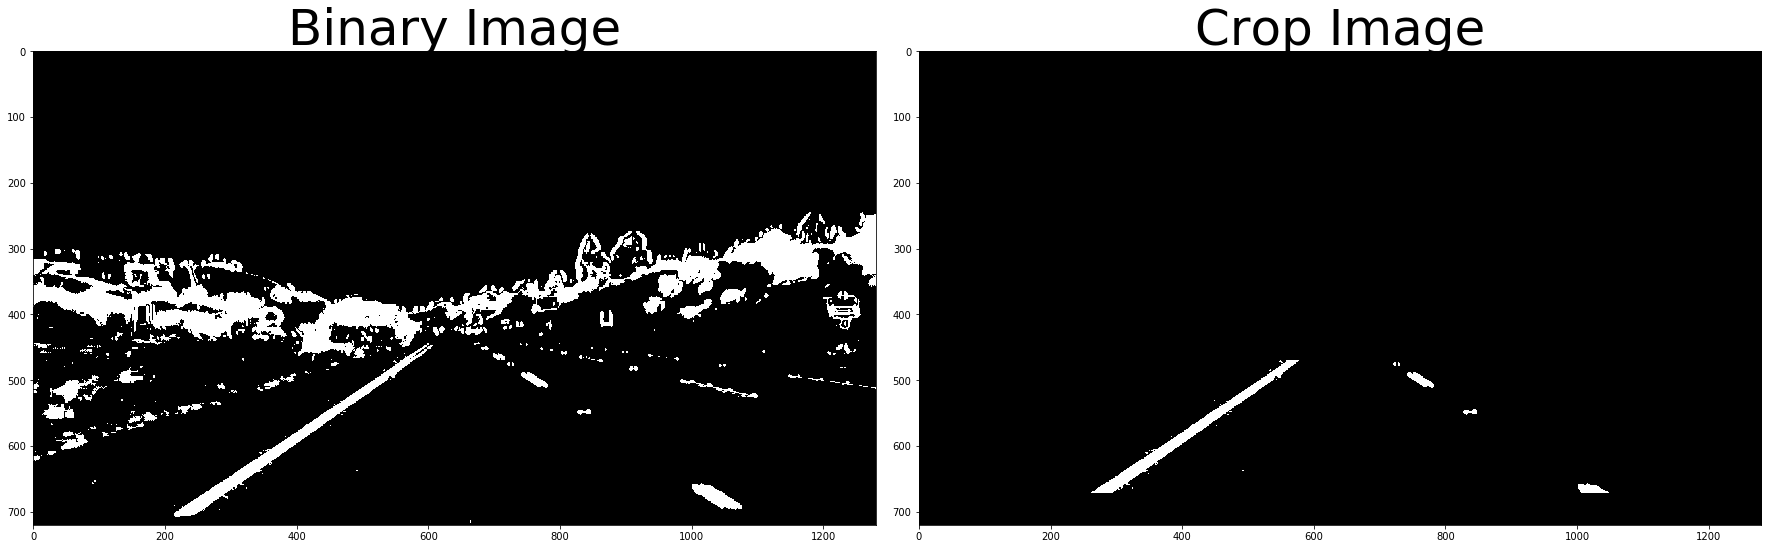

In [9]:
height, width = img.shape[0], img.shape[1]
src = [
    ((width // 2) - 70, (height // 2) + 110), 
    ((width // 2) + 80, (height // 2) + 110), 
    (width - 170, height), 
    (0 + 220, height)
]
dst = [
    (width // 4, 0), 
    (width - width // 4 - 40, 0), 
    (width - width // 4 - 40, height), 
    (width // 4, height)
]

print('src: %s' % src)
print('dst: %s' % dst)
vertices = np.int32([[
    (src[0][0] - 60, src[0][1]),
    (src[1][0] + 60, src[1][1]),
    (src[2][0] + 60, src[2][1] - 50),
    (src[3][0] - 60, src[3][1] - 50)]]
)
print('region of interest: %s' % vertices)
img_crop = region_of_interest(img_binary, vertices)
plot_comparison(
    img_binary,
    img_crop,
    title1='Binary Image',
    title2='Crop Image',
    cmap1='gray',
    cmap2='gray'
)

## Perspective Transform
Apply a perspective transform to rectify binary image ("birds-eye view")

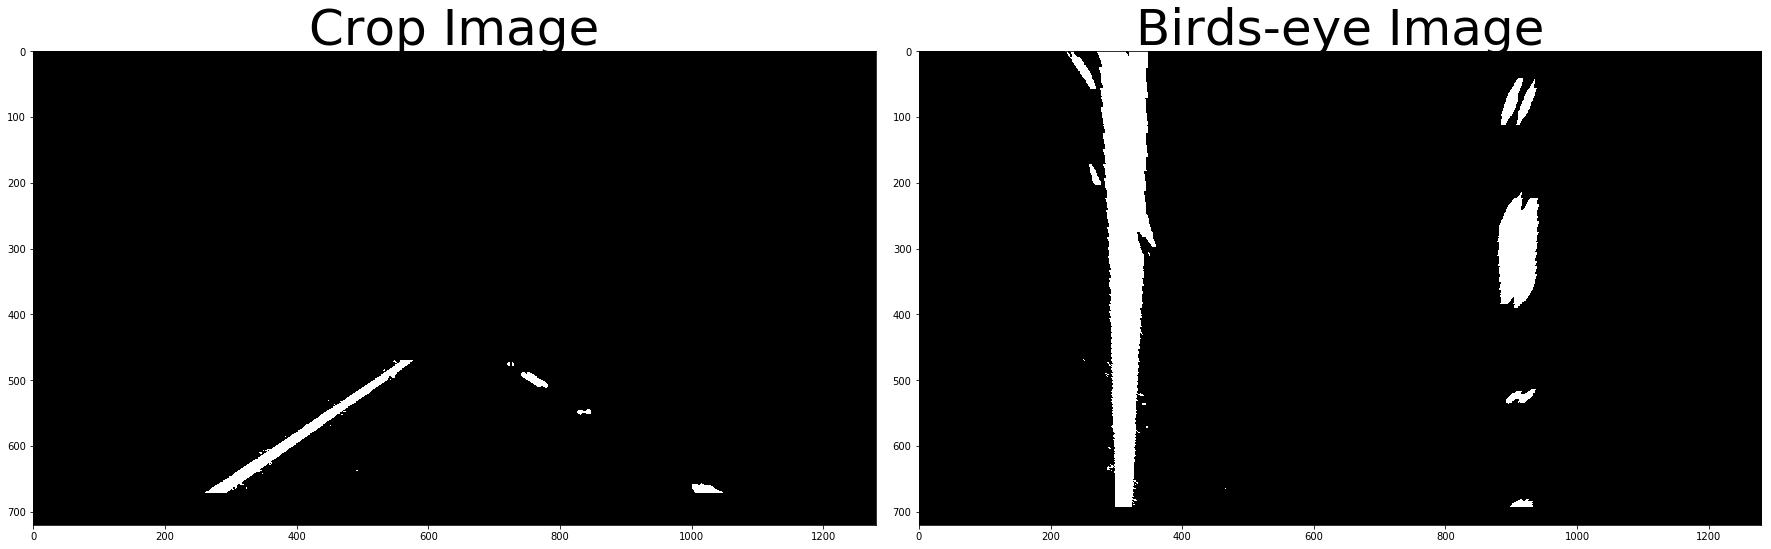

In [10]:
img_unwarp, M, Minv = warper(img_crop, np.float32(src), np.float32(dst))
plot_comparison(
    img_crop,
    img_unwarp,
    title1='Crop Image',
    title2='Birds-eye Image',
    cmap1='gray',
    cmap2='gray'    
)

## Image Histogram

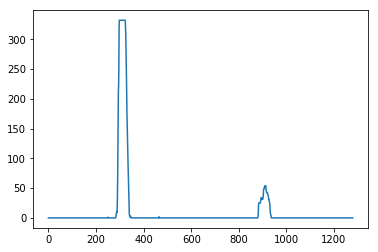

In [11]:
h = histogram(img_unwarp)
plot_histogram(h)

## Drawing the lane


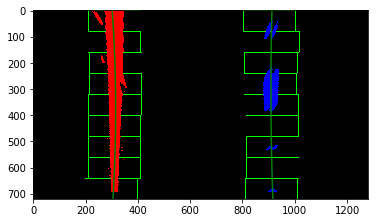

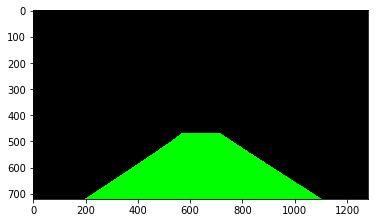

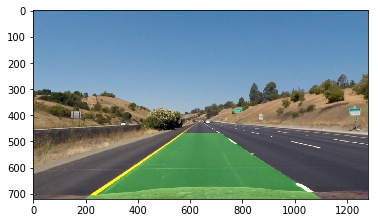

In [12]:
from lane import Lane
lane = Lane()
img_out = lane.draw(img, verbose=1)
fig, ax = plt.subplots(dpi=160)
ax.imshow(img_out)
plt.show()